## Importer les Packages

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import warnings
warnings.filterwarnings('ignore')

## Charger les Données

In [ ]:
data = pd.read_csv('Data/smart_grid_dataset.csv')

# Description des données
print(f"Dimensions du dataset : {data.shape}")
print("\nInformations sur les colonnes :")
print(data.info())
print("\nStatistiques descriptives :")
print(data.describe())

"""
Source et description :
Ce dataset contient des mesures d'un réseau électrique intelligent collectées toutes les 15 minutes
sur 5 jours (du 1er au 5 janvier 2024). Il comprend :
- Mesures électriques (tension, courant, puissance)
- Production d'énergie renouvelable (solaire, éolien)
- Données environnementales (température, humidité)
- Prix de l'électricité
- Prédictions de charge
- Indicateurs de santé du réseau
"""

## Analyse des données


Valeurs manquantes par colonne :
Timestamp                      0
Voltage (V)                    0
Current (A)                    0
Power Consumption (kW)         0
Reactive Power (kVAR)          0
Power Factor                   0
Solar Power (kW)               0
Wind Power (kW)                0
Grid Supply (kW)               0
Voltage Fluctuation (%)        0
Overload Condition             0
Transformer Fault              0
Temperature (°C)               0
Humidity (%)                   0
Electricity Price (USD/kWh)    0
Predicted Load (kW)            0
Hour                           0
Day                            0
dtype: int64


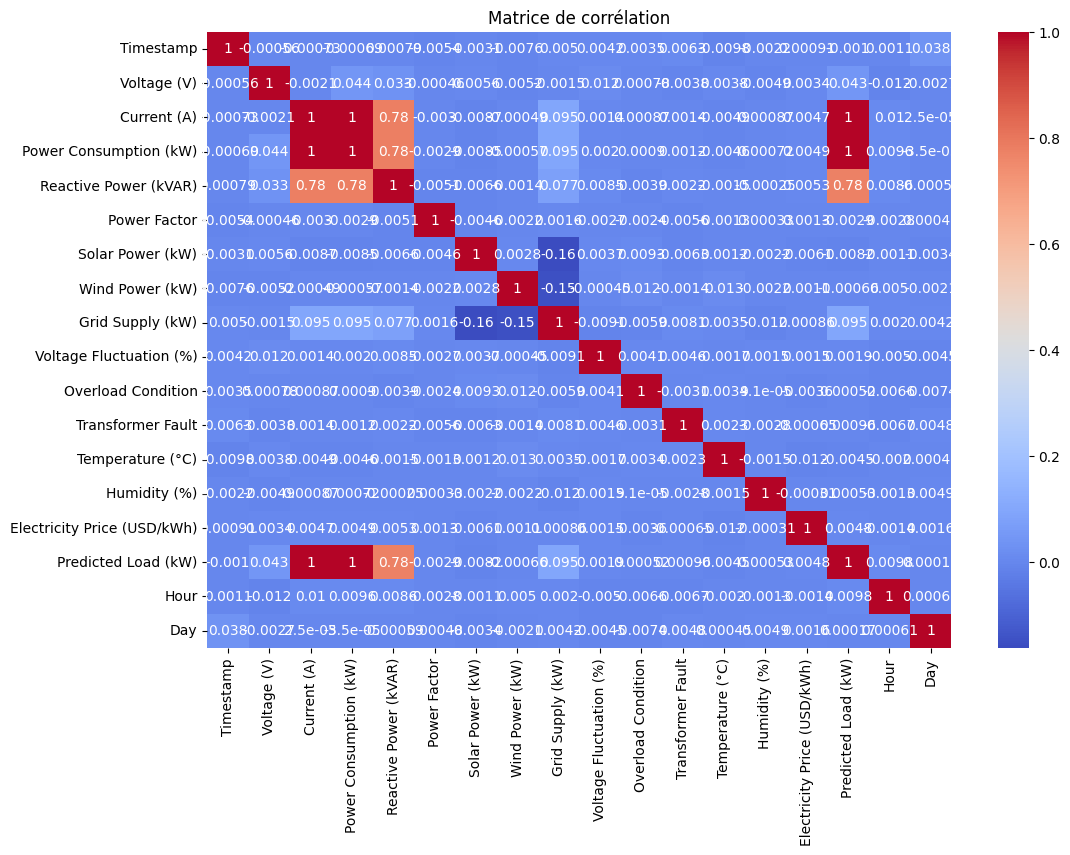

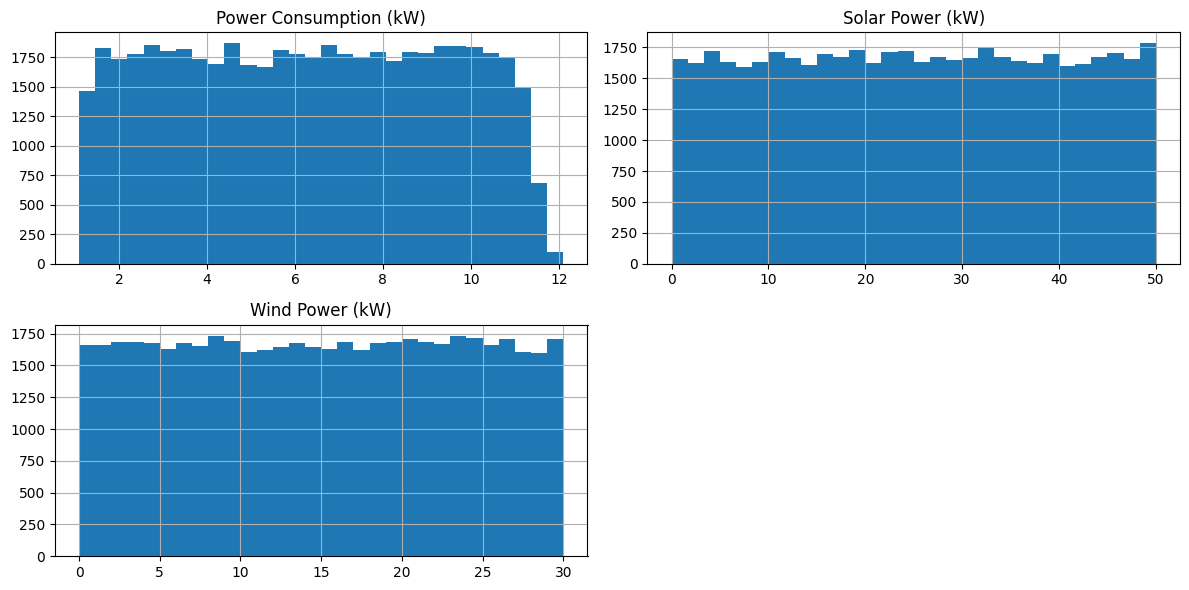

In [13]:
# Vérification des valeurs manquantes
print("\nValeurs manquantes par colonne :")
print(data.isnull().sum())

# Analyse des corrélations
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()

# Distribution des variables clés
data[['Power Consumption (kW)', 'Solar Power (kW)', 'Wind Power (kW)']].hist(bins=30, figsize=(12,6))
plt.tight_layout()
plt.show()


## Prétraitement des données

In [14]:
# Conversion du timestamp
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['Hour'] = data['Timestamp'].dt.hour
data['Day'] = data['Timestamp'].dt.day

# Gestion des variables catégorielles (si nécessaire)
# Ici nos variables binaires sont déjà encodées (0/1)

# Sélection des features
features = ['Voltage (V)', 'Current (A)', 'Solar Power (kW)', 'Wind Power (kW)', 
            'Temperature (°C)', 'Humidity (%)', 'Hour', 'Day']
target = 'Power Consumption (kW)'

X = data[features]
y = data[target]

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Division des données

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Construction du modèle

In [ ]:
# Approche Machine Learning (Random Forest)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Approche Deep Learning (pour comparaison)
dl_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

dl_model.compile(optimizer='adam', loss='mse')
history = dl_model.fit(X_train, y_train, epochs=50, batch_size=32, 
                       validation_split=0.2, verbose=0)
dl_pred = dl_model.predict(X_test).flatten()

## Visualisation des données et résultats

In [ ]:
# Comparaison des prédictions
plt.figure(figsize=(12,6))
plt.plot(y_test.values[:50], label='Valeurs réelles')
plt.plot(rf_pred[:50], label='Random Forest')
plt.plot(dl_pred[:50], label='Deep Learning')
plt.legend()
plt.title('Comparaison des prédictions')
plt.xlabel('Échantillons')
plt.ylabel('Puissance (kW)')
plt.show()

# Importance des features
feat_importances = pd.Series(rf_model.feature_importances_, index=features)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Importance des variables (Random Forest)')
plt.show()

## Évaluation des modèles

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\nPerformance du modèle {model_name}:")
    print(f"MAE: {mae:.3f}")
    print(f"R²: {r2:.3f}")
    return mae, r2

rf_mae, rf_r2 = evaluate_model(y_test, rf_pred, "Random Forest")
dl_mae, dl_r2 = evaluate_model(y_test, dl_pred, "Deep Learning")

# Visualisation des erreurs
errors = pd.DataFrame({
    'Model': ['Random Forest', 'Deep Learning'],
    'MAE': [rf_mae, dl_mae],
    'R2': [rf_r2, dl_r2]
})

melted = errors.melt(id_vars='Model', var_name='Metric', value_name='Value')
sns.barplot(x='Model', y='Value', hue='Metric', data=melted)
plt.title('Comparaison des performances des modèles')
plt.show()